In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import shuffle

In [2]:
designs = pd.read_csv('<path/to/your>/selected_designs_with_metrics.csv', #this is generated by ../05_filtering/final_filtering.ipynb
                      index_col=False)

### Make shorter names for the designs

In [3]:
def short_name(full_name,i):
    num = f'{i:05}'
    
    short_name = 'H2Db_'+num
    if 'std' in full_name:
        short_name += '_std'
    if 'nat' in full_name:
        short_name += '_nat'
    if '.' in full_name:
        short_name += '_graft'
        
    return short_name

In [4]:
designs.insert(len(designs.columns),'short_name',[short_name(row['name'],i) for i,row in designs.iterrows()])

In [5]:
designs.to_csv('<desired/path/to>/selected_designs_with_metrics_renamed.csv')

# Generate scrambled designs
code borrowed from Hua Bai

In [6]:
# function from Hua (/home/huabai/fuse_mini/prepare_201908_Agilent_Chip/scripts/make_scramble.py)
def group_and_shuffle_seq(input_seq):
    group_1 = 'RHKDESTNQC' # polar or charged
    group_2 = 'AVILMFYW'   # hydrophobic
    group_3 = 'GP'         # special
    index = 0; # 0-base

    seq_1_aa=""
    seq_1_num=[]
    seq_2_aa=""
    seq_2_num=[]
    seq_3_aa=""
    seq_3_num=[]

    output_seq = [0]*len(input_seq)

    for i in input_seq:
        if i in group_1:
            seq_1_aa+=i
            seq_1_num.append(index)
        elif i in group_2:
            seq_2_aa+=i
            seq_2_num.append(index)
        elif i in group_3:
            seq_3_aa+=i
            seq_3_num.append(index)
        else:
            print("error")
            print(i)

        index+=1

#     print("Polar: " + seq_1_aa)
#     print("Hydrophobic: "+ seq_2_aa)
#     print("Gly+Pro: " + seq_3_aa)

    list_seq_1_aa = list(seq_1_aa)
    shuffle(list_seq_1_aa)
    seq_1_aa = "".join(list_seq_1_aa)

    list_seq_2_aa = list(seq_2_aa)
    shuffle(list_seq_2_aa)
    seq_2_aa = "".join(list_seq_2_aa)

    # NOT shuffle Gly and Pro, so the below codes are not used.
    combine_aa = seq_1_aa + seq_2_aa + seq_3_aa
    combine_num= seq_1_num + seq_2_num + seq_3_num

    for i, this_aa in zip(combine_num, combine_aa):
        output_seq[i] = this_aa

    output_seq=''.join(output_seq)
    return output_seq

In [7]:
to_scramble = designs.sample(11000-len(designs))
scrambled = []
for i,row in to_scramble.iterrows():
    scrambled.append([row['short_name']+'_shuf',
                      group_and_shuffle_seq(row['binder_seq']),
                      row['length']])
scrambled = pd.DataFrame(scrambled,columns=['short_name','binder_seq','length'])

scrambled.to_csv('<desired/path/to>/scrambles.csv')

# Write fasta with all unique protein seqs
Barcodes and designs/scrambles will be codon optimiized separately and then combined as DNA sequences later

In [8]:
all_seqs = designs.append(scrambled,ignore_index=True)

with open('<desired/path/to>/designs_and_scrambles_aa.fasta','w') as f:
    for i,row in all_seqs.iterrows():
        f.write('>{}\n{}\n'.format(row['short_name'],row['binder_seq']))

In [9]:
barcodes = pd.read_csv('standard_barcodes_ms1_70000.csv')

#filter out high iRT barcodes because they are more likely to cause issues for the designs
barcodes = barcodes[barcodes['iRT']<100]
barcodes.index = range(len(barcodes))
barcodes.to_csv('standard_barcodes_ms1_70000_iRT100.csv')
print(len(barcodes))

with open('<desired/path/to>/standard_barcodes_ms1_70000_iRT100_aa.fasta','w') as f:
    for i,row in barcodes.iterrows():
        f.write('>barcode_{}\n{}\n'.format(i,row['sequence']))

49933


# Pair designs with barcodes
This part gets run after codon optimization is finished

Each design gets 4 barcodes

In [16]:
def read_fasta(fname):
    with open(fname,'r') as f:
        line = f.readline()
        
        df_out = []
        entry = []
        while line:
            entry.append(line.replace('\n','').replace('>',''))
            if len(entry) == 2:
                df_out.append(entry)
                entry = []
            line = f.readline()
        return pd.DataFrame(df_out,columns=['name','sequence'])

In [17]:
barcodes = read_fasta('standard_barcodes_ms1_70000_iRT100_dna.fasta')
designs = read_fasta('designs_and_scrambles_dna.fasta')
adapters = read_fasta('selected_primers.fasta')

In [18]:
assembled_seqs = []
barcodes_per_design = 4

adapter_5 = adapters[adapters['name']=='adapter_5']['sequence'].values[0]
adapter_3 = adapters[adapters['name']=='adapter_3']['sequence'].values[0]
BamHI = adapters[adapters['name']=='BamHI_plus']['sequence'].values[0]

barcode_idx = 0
for i,row in designs.iterrows():
    design_name = row['name']
    design_seq = row['sequence']

    for b in range(barcodes_per_design):
        barcode_name = barcodes.loc[barcode_idx,'name']
        barcode_seq = barcodes.loc[barcode_idx,'sequence']
        assembled_seqs.append([design_name+'_'+str(b),
                                 barcode_name,
                                 design_seq,
                                 barcode_seq,
                                 adapter_5+barcode_seq+BamHI+design_seq+adapter_3])
        barcode_idx += 1

assembled_seqs = pd.DataFrame(assembled_seqs,
                              columns=['design_name','barcode_name','binder_seq','barcode_seq','full_seq'])
assembled_seqs.insert(len(assembled_seqs.columns),'length',assembled_seqs['full_seq'].map(lambda x: len(x)))
max(assembled_seqs['length'])

267

<AxesSubplot:xlabel='length'>

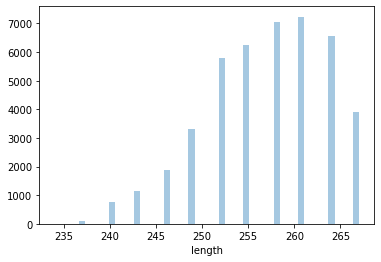

In [19]:
sns.distplot(assembled_seqs['length'],kde=False)

In [20]:
assembled_seqs.to_csv('<desired/path/to>/full_seqs_dna_300mer.csv')

with open('<desired/path/to>/full_seqs_dna_300mer.fasta','w') as f:
    for i,row in assembled_seqs.iterrows():
        f.write('>{}\n{}\n'.format(row['design_name'],row['full_seq']))
        
with open('<desired/path/to>/full_seqs_dna_300mer.list','w') as f:
    for i,row in assembled_seqs.iterrows():
        f.write('{}\n'.format(row['full_seq']))

In [21]:
min(assembled_seqs['length'])

234